In [233]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict


from utils import run_and_cache
from TSTtrainer import  TimeSeriesTransformer, load_dataset

In [234]:
torch.manual_seed(123)
np.random.seed(123)

In [235]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [236]:
ACTIVATION_TENSOR = None

In [237]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, sparsity_lambda=1e-3):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.sparsity_lambda = sparsity_lambda

    def forward(self, x):
        h = F.relu(self.encoder(x))
        x_hat = self.decoder(h)
        return x_hat, h
    
    def loss(self, x, x_hat, h):
        reconstruction_loss = F.mse_loss(x_hat, x)
        sparsity_penalty = self.sparsity_lambda * torch.sum(torch.abs(h))
        return reconstruction_loss + sparsity_penalty

In [238]:
MODEL_PATH = "TST_japanesevowels.pth"
DATASET_NAME = "JapaneseVowels"
LAYER_TARGETS = ["transformer_encoder.layers.0.linear2"]

In [239]:
train_loader, test_loader = load_dataset(DATASET_NAME, batch_size=4)

full_train_inputs = []
full_train_labels = []
for x, y in train_loader:
    full_train_inputs.append(x)
    full_train_labels.append(y)

train_batch = torch.cat(full_train_inputs).to(DEVICE)  # (N, seq_len, channels)
label_batch = torch.cat(full_train_labels)             # (N,)

train_labels = label_batch
seq_len, channels = train_batch.shape[1], train_batch.shape[2]
num_classes = int(train_labels.max().item()) + 1

model = TimeSeriesTransformer(
    input_dim=channels,
    num_classes=num_classes,
    seq_len=seq_len
)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE).eval()

In [240]:
cache = run_and_cache(model, train_batch, targets=LAYER_TARGETS)
activations = list(cache.values())[0]
ACTIVATION_TENSOR = activations.view(-1, activations.size(-1)).cpu()
flat_labels = train_labels.view(-1, 1).repeat(1, seq_len).view(-1)


In [241]:
dataset = TensorDataset(ACTIVATION_TENSOR)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [242]:
input_dim = ACTIVATION_TENSOR.shape[1]
hidden_dim = 128
sparsity_lambda = 1e-4

sae = SparseAutoencoder(input_dim, hidden_dim, sparsity_lambda).to(DEVICE)
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-3)

num_epochs = 100
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    sae.train()
    for batch in dataloader:
        x = batch[0].to(DEVICE)
        x_hat, h = sae(x)
        loss = sae.loss(x, x_hat, h)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x.size(0)

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)

    print(f"epoch {epoch}, loss {avg_loss}")

epoch 0, loss 16.321507343706095
epoch 1, loss 7.856044866988119
epoch 2, loss 6.044982434443708
epoch 3, loss 5.153139863795829
epoch 4, loss 4.6051263293286535
epoch 5, loss 4.235989910603132
epoch 6, loss 3.9485087740533755
epoch 7, loss 3.731554317165096
epoch 8, loss 3.5493435164526947
epoch 9, loss 3.400058180304631
epoch 10, loss 3.2711228181449874
epoch 11, loss 3.1585663301202485
epoch 12, loss 3.065909723487665
epoch 13, loss 2.9895854943765783
epoch 14, loss 2.907762542859001
epoch 15, loss 2.8325949169273645
epoch 16, loss 2.779332119830937
epoch 17, loss 2.7184599379323564
epoch 18, loss 2.6573608864871963
epoch 19, loss 2.626161271671079
epoch 20, loss 2.5646986884750285
epoch 21, loss 2.504504189949553
epoch 22, loss 2.4609765095530816
epoch 23, loss 2.4418506005181455
epoch 24, loss 2.403477132320404
epoch 25, loss 2.378265974832312
epoch 26, loss 2.3219627155658773
epoch 27, loss 2.3039208485411025
epoch 28, loss 2.253517417342595
epoch 29, loss 2.2397919919271514
epoc

all_hidden shape: torch.Size([6750, 128])
Nonzero entries per row: tensor([21, 25, 25, 25, 23, 23, 27, 23, 24, 33])
Max value: 2.3009917736053467
Min value: 0.0


<function matplotlib.pyplot.show(close=None, block=None)>

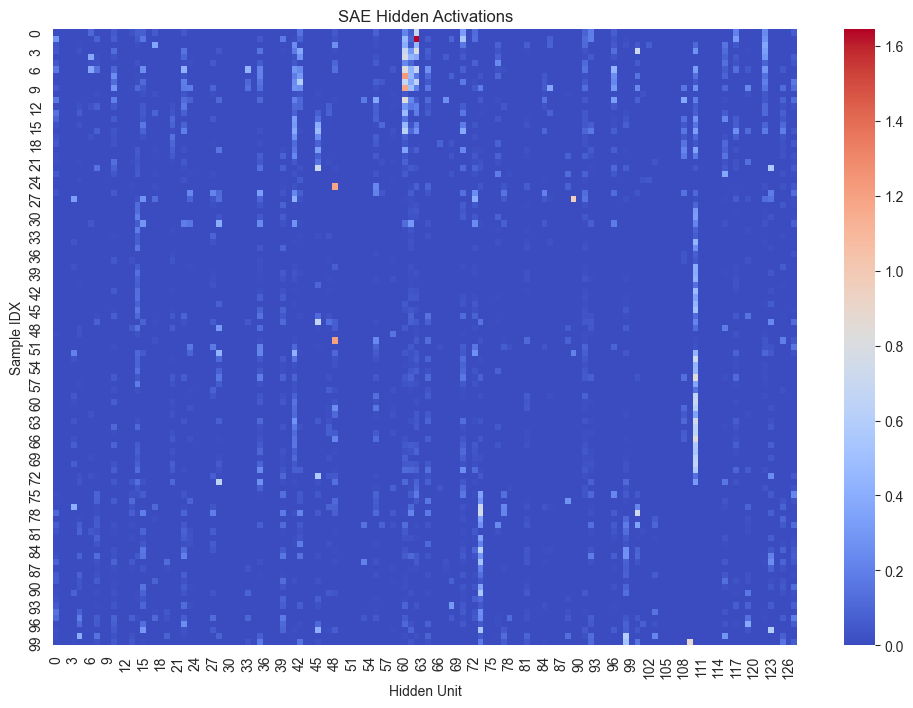

In [243]:
sae.eval()
all_hidden = []

# Use non-shuffled loader to ensure full data pass
full_loader = DataLoader(TensorDataset(ACTIVATION_TENSOR), batch_size=512, shuffle=False)

with torch.no_grad():
    for batch in full_loader:
        x = batch[0].to(DEVICE)
        _, h = sae(x)
        all_hidden.append(h.cpu())

all_hidden = torch.cat(all_hidden)

print("all_hidden shape:", all_hidden.shape)
print("Nonzero entries per row:", (all_hidden != 0).sum(dim=1)[:10])
print("Max value:", all_hidden.max().item())
print("Min value:", all_hidden.min().item())

plt.figure(figsize=(12, 8))
sns.heatmap(all_hidden[:100], cmap="coolwarm")
plt.xlabel("Hidden Unit")
plt.ylabel("Sample IDX")
plt.title("SAE Hidden Activations")
plt.show

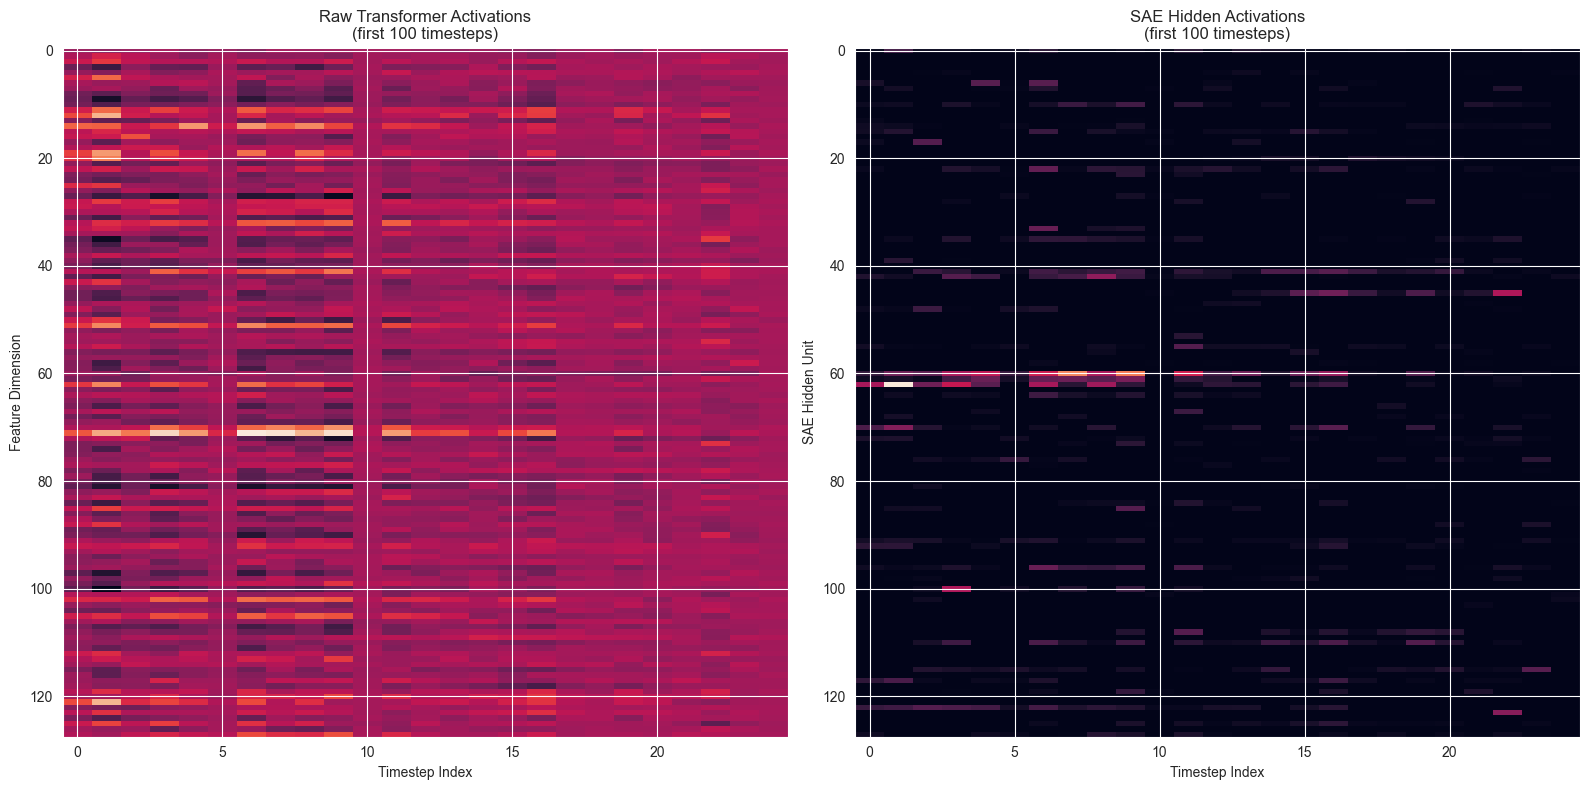

In [253]:
raw_acts = ACTIVATION_TENSOR[:25].numpy()  # shape: (100, d_model)

# 2. Prepare SAE Hidden Activations (first 100 timesteps)
sae.eval()
sae_hidden = []
with torch.no_grad():
    for batch in DataLoader(TensorDataset(ACTIVATION_TENSOR[:25]), batch_size=100, shuffle=False):
        x = batch[0].to(DEVICE)
        _, h = sae(x)
        sae_hidden.append(h.cpu().numpy())
sae_hidden = sae_hidden[0]  # shape: (100, hidden_dim)

# 3. Plot side-by-side heatmaps using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left: Raw Transformer Activations
im0 = axes[0].imshow(raw_acts.T, aspect='auto')
axes[0].set_title("Raw Transformer Activations\n(first 100 timesteps)")
axes[0].set_xlabel("Timestep Index")
axes[0].set_ylabel("Feature Dimension")

# Right: SAE Hidden Activations
im1 = axes[1].imshow(sae_hidden.T, aspect='auto')
axes[1].set_title("SAE Hidden Activations\n(first 100 timesteps)")
axes[1].set_xlabel("Timestep Index")
axes[1].set_ylabel("SAE Hidden Unit")

plt.tight_layout()
plt.show()

In [258]:
sae.eval()
with torch.no_grad():
    batch = ACTIVATION_TENSOR[:25].to(DEVICE)
    _, h = sae(batch)               # h: (25, hidden_dim)
    sae_hidden = h.cpu().numpy()    # → shape (25, 64)

# 2) Flatten and find top-K
K = 10
flat = sae_hidden.flatten()                    # shape (25*64,)
topk_idxs = np.argpartition(flat, -K)[-K:]     # indices of top-K (unordered)
topk_sorted = topk_idxs[np.argsort(flat[topk_idxs])[::-1]]  # sort descending

# 3) Convert back to (timestep, neuron)
timesteps = topk_sorted // sae_hidden.shape[1]
neurons    = topk_sorted %  sae_hidden.shape[1]
values     = flat[topk_sorted]

# 4) Print them
print(f"Top {K} SAE activations in the first 25 timesteps:")
for t, n, v in zip(timesteps, neurons, values):
    print(f"  • Timestep {t:2d}, Neuron {n:2d} → activation = {v:.4f}")

# 5) (Optional) Unique neurons among those top-K
u = np.unique(neurons)
print("\nUnique neurons in top-K:", u.tolist())

Top 10 SAE activations in the first 25 timesteps:
  • Timestep  1, Neuron 62 → activation = 1.6430
  • Timestep  7, Neuron 60 → activation = 1.2261
  • Timestep  9, Neuron 60 → activation = 1.1822
  • Timestep 11, Neuron 60 → activation = 0.8406
  • Timestep  6, Neuron 60 → activation = 0.8306
  • Timestep  3, Neuron 62 → activation = 0.7959
  • Timestep  4, Neuron 60 → activation = 0.7753
  • Timestep 22, Neuron 45 → activation = 0.7110
  • Timestep  3, Neuron 100 → activation = 0.7093
  • Timestep  8, Neuron 60 → activation = 0.6936

Unique neurons in top-K: [45, 60, 62, 100]


In [266]:
# From your top-K analysis on the first 25 timesteps:
topk = [
    (1,  62),
    (7,  60),
    (9,  60),
    (11, 60),
    (6,  60),
    (3,  62),
    (4,  60),
    (22, 45),
    (3,  100),
    (8,  60),
]
timesteps, neurons = zip(*topk)  # two tuples of length 10

import torch
import torch.nn.functional as F

# 1) Pick your sequence (first instance here)
instance_idx = 0
seq = train_batch[instance_idx].unsqueeze(0).to(DEVICE)  # (1, seq_len, channels)

# 2) Baseline
probs_before = F.softmax(model(seq), dim=-1)[0]

# 3) Hook that patches only the top-K spots
layer = model.transformer_encoder.layers[0].linear2

def patch_hook(module, inp, out):
    # out: (B=1, T, D)
    h = F.relu(sae.encoder(out))  # (1, T, H)
    # clamp only the exact (t, n) spots
    for t, n in zip(timesteps, neurons):
        h[:, t, n] = 0.0
    return sae.decoder(h)

hook = layer.register_forward_hook(patch_hook)

# 4) After patch
probs_after = F.softmax(model(seq), dim=-1)[0]
hook.remove()

# 5) Print comparison
print("Before:", probs_before.tolist())
print(" After:", probs_after.tolist())
print("Δ for each class:")
for c, (p0, p1) in enumerate(zip(probs_before, probs_after)):
    print(f"  class {c:2d}: {p0:.3f} → {p1:.3f}  (Δ {p1-p0:+.3f})")



Before: [5.927896751245498e-08, 9.495241829426959e-05, 9.635085916670505e-06, 0.0012630807468667626, 0.9983428716659546, 8.153315320669208e-06, 8.814386819722131e-05, 9.264862455893308e-05, 9.887898340821266e-05, 1.58489717705379e-06]
 After: [1.1099732688535369e-07, 0.0002206945646321401, 1.2180434168840293e-05, 0.002600625855848193, 0.9966980218887329, 8.32935438666027e-06, 0.00023792100546415895, 0.00010792033572215587, 0.00011218996223760769, 2.0698373646155233e-06]
Δ for each class:
  class  0: 0.000 → 0.000  (Δ +0.000)
  class  1: 0.000 → 0.000  (Δ +0.000)
  class  2: 0.000 → 0.000  (Δ +0.000)
  class  3: 0.001 → 0.003  (Δ +0.001)
  class  4: 0.998 → 0.997  (Δ -0.002)
  class  5: 0.000 → 0.000  (Δ +0.000)
  class  6: 0.000 → 0.000  (Δ +0.000)
  class  7: 0.000 → 0.000  (Δ +0.000)
  class  8: 0.000 → 0.000  (Δ +0.000)
  class  9: 0.000 → 0.000  (Δ +0.000)


In [265]:
hidden_by_class = defaultdict(list)


with torch.no_grad():
    x_tensor = ACTIVATION_TENSOR.to(DEVICE)
    _, all_h = sae(x_tensor)
    all_h = all_h.cpu()

for h_vec, label in zip(all_h, flat_labels):
    hidden_by_class[label.item()].append(h_vec)

plt.figure(figsize=(12, 8))
for cls, activations, in hidden_by_class.items():
    avg_activation = torch.stack(activations).mean(dim=0)
    topk = torch.topk(avg_activation, k=5).indices.tolist()
    print(f"Class {cls}: Top-5 active SAE units - {topk}")

Class 4: Top-5 active SAE units - [60, 62, 45, 70, 61]
Class 6: Top-5 active SAE units - [110, 14, 48, 41, 35]
Class 2: Top-5 active SAE units - [73, 98, 123, 7, 100]
Class 9: Top-5 active SAE units - [39, 91, 58, 35, 81]
Class 8: Top-5 active SAE units - [13, 72, 91, 117, 42]
Class 3: Top-5 active SAE units - [41, 84, 20, 10, 123]
Class 1: Top-5 active SAE units - [122, 101, 15, 60, 7]
Class 7: Top-5 active SAE units - [61, 98, 125, 42, 14]
Class 5: Top-5 active SAE units - [0, 77, 33, 100, 81]


<Figure size 1200x800 with 0 Axes>

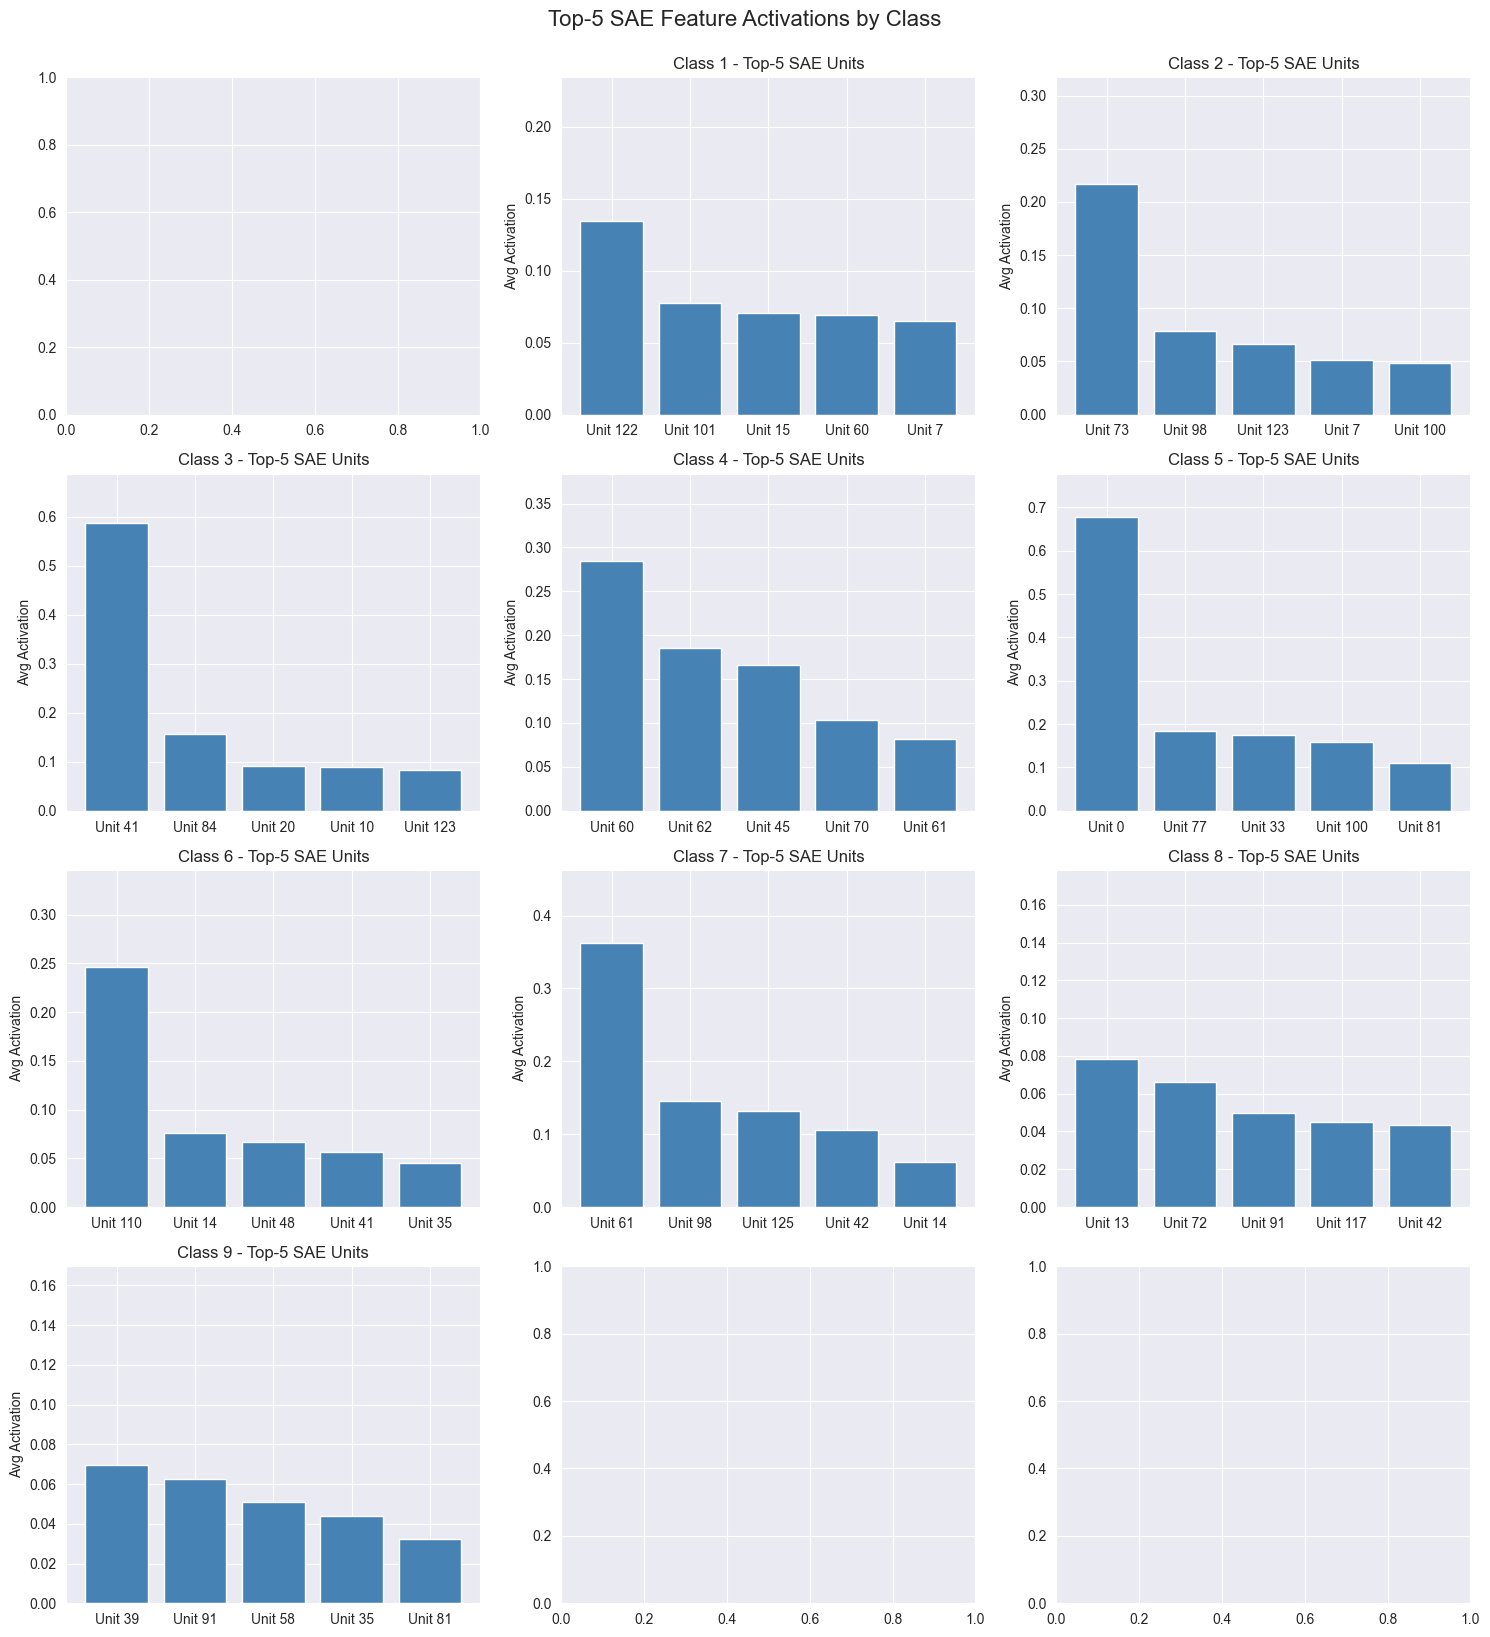

In [246]:
fig, axes = plt.subplots(nrows=num_classes // 3 + 1, ncols=3, figsize=(15, 4 * ((num_classes // 3) + 1)))
axes = axes.flatten()

for cls, activations in hidden_by_class.items():
    avg_activation = torch.stack(activations).mean(dim=0)
    topk_vals, topk_indices = torch.topk(avg_activation, k=5)

    ax = axes[cls]
    ax.bar([f"Unit {i}" for i in topk_indices], topk_vals.numpy(), color='steelblue')
    ax.set_title(f"Class {cls} - Top-5 SAE Units")
    ax.set_ylabel("Avg Activation")
    ax.set_ylim(0, topk_vals.max().item() + 0.1)
    ax.grid(True)

plt.tight_layout()
plt.suptitle("Top-5 SAE Feature Activations by Class", fontsize=16, y=1.02)
plt.show()

In [247]:
target_unit = 33
k = 5

# Find top-k activations for this unit
unit_activations = all_hidden[:, target_unit]
topk_indices = torch.topk(unit_activations, k=k).indices

# Print top-k activations and their sample indices
print(f"Top-{k} activations for SAE unit {target_unit}:")
for idx in topk_indices:
    print(f"Sample {idx.item()}, activation: {unit_activations[idx].item():.4f}")

Top-5 activations for SAE unit 33:
Sample 1034, activation: 1.1981
Sample 6536, activation: 1.1383
Sample 3486, activation: 1.1036
Sample 4831, activation: 1.1025
Sample 3478, activation: 1.0892


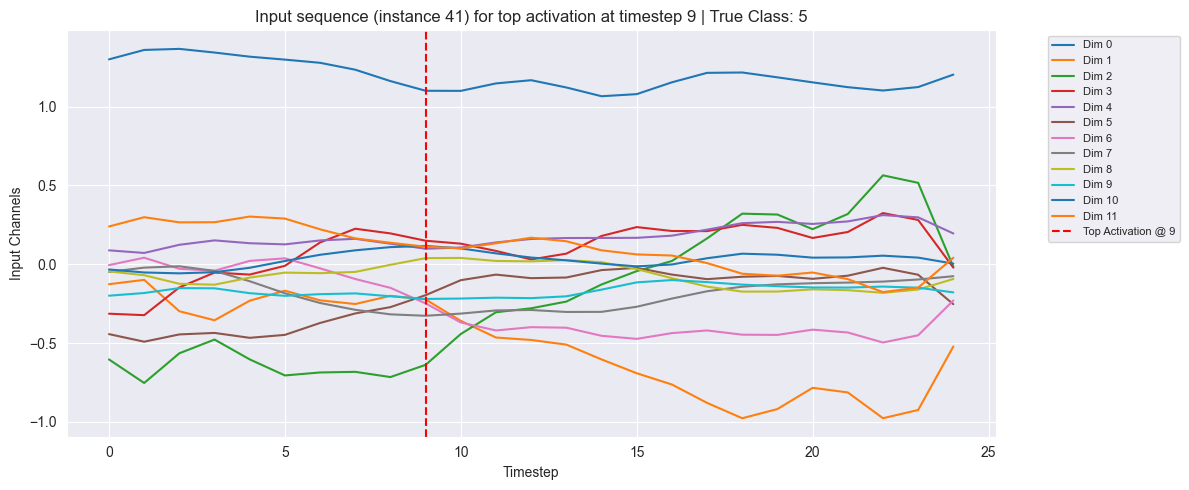

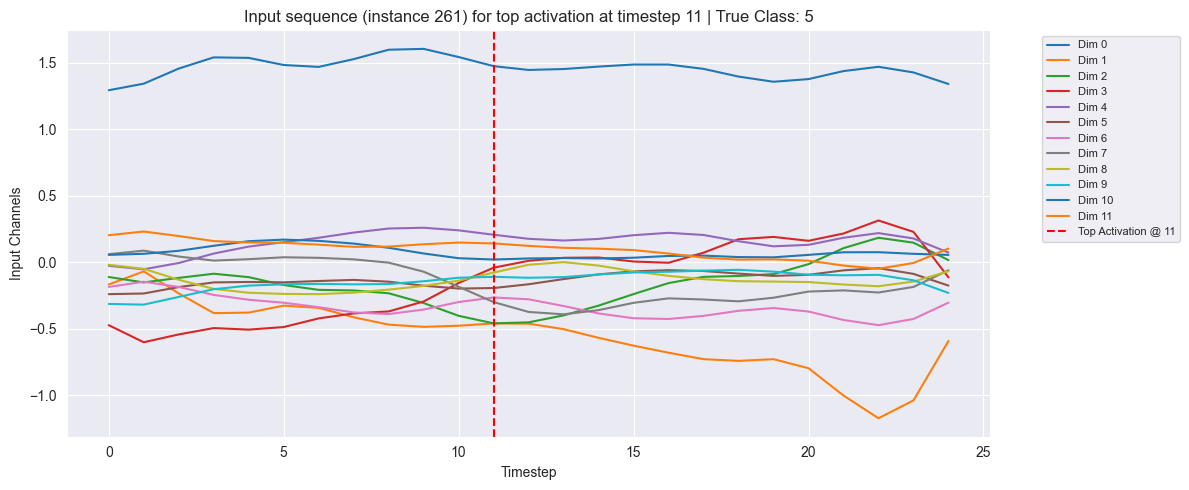

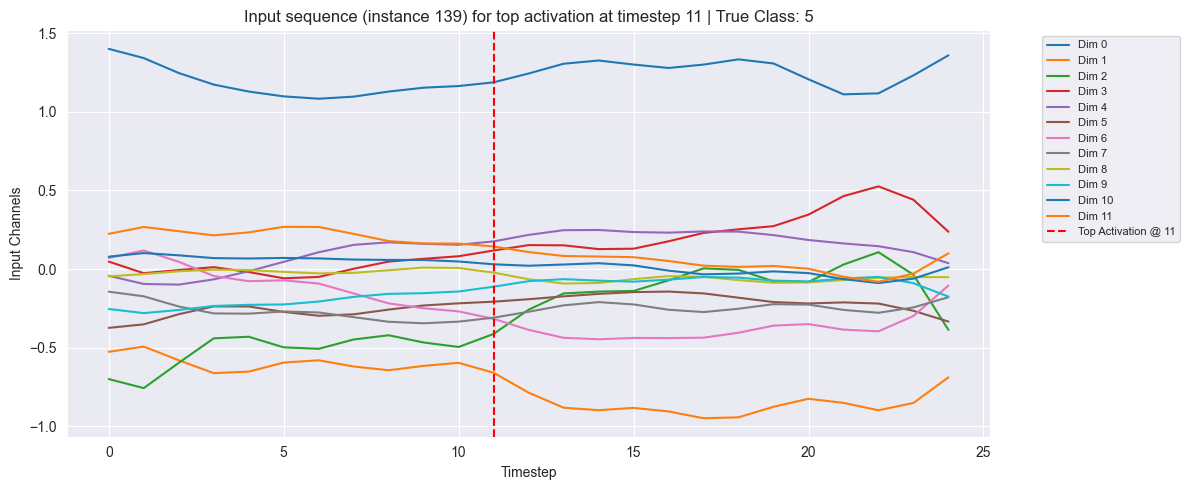

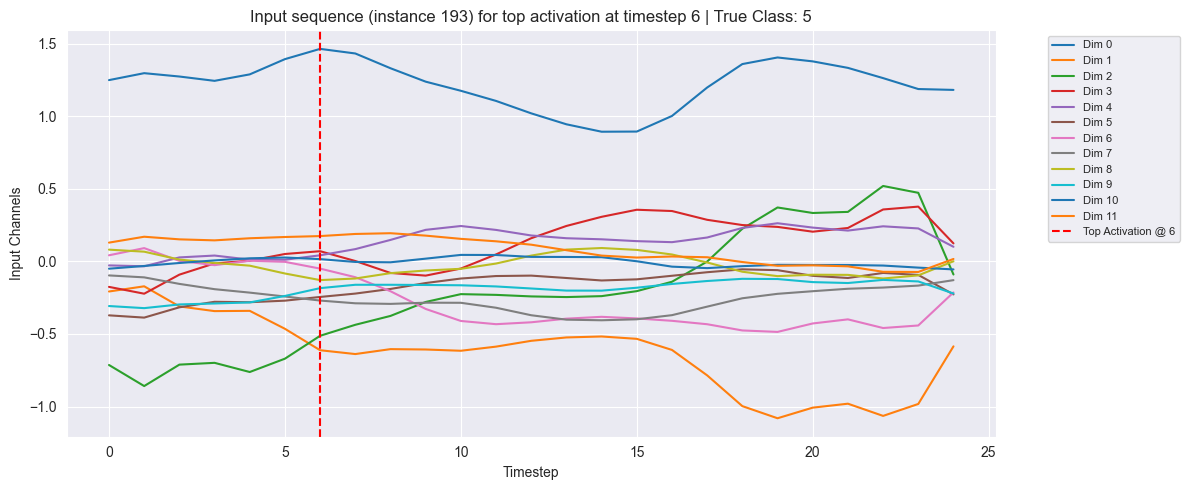

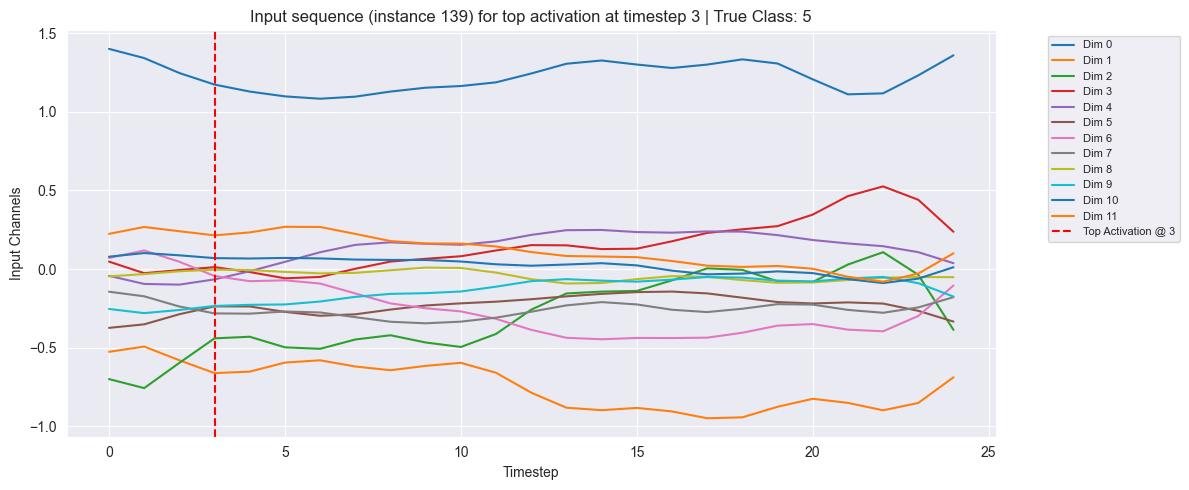

In [248]:
for idx in topk_indices:
    instance_id = idx.item() // seq_len
    timestep_id = idx.item() % seq_len

    # Extract full input sequence
    input_seq = train_batch[instance_id].cpu().numpy()  # shape: (seq_len, channels)

    # Get true class label
    true_class = train_labels[instance_id].item()

    # Plot full sequence with vertical line highlighting the top-activating timestep
    plt.figure(figsize=(12, 5))
    for dim in range(input_seq.shape[1]):
        plt.plot(input_seq[:, dim], label=f"Dim {dim}")

    plt.axvline(x=timestep_id, color='red', linestyle='--', label=f"Top Activation @ {timestep_id}")
    plt.title(f"Input sequence (instance {instance_id}) for top activation at timestep {timestep_id} | True Class: {true_class}")
    plt.xlabel("Timestep")
    plt.ylabel("Input Channels")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

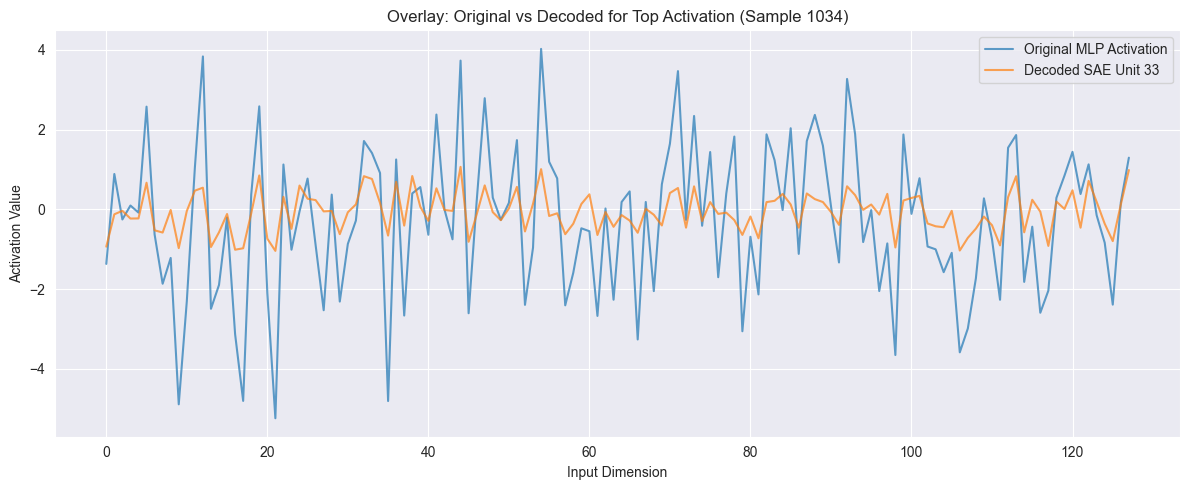

In [249]:
unit_vector = torch.zeros(hidden_dim)
unit_vector[target_unit] = 1.0
unit_vector = unit_vector.to(DEVICE).unsqueeze(0)

with torch.no_grad():
    decoded_pattern = sae.decoder(unit_vector).cpu().squeeze()

idx = topk_indices[0]  # Use the top-activated sample
original_activation = ACTIVATION_TENSOR[idx].numpy()
decoded_vector = decoded_pattern.numpy()

plt.figure(figsize=(12, 5))
plt.plot(original_activation, label="Original MLP Activation", alpha=0.7)
plt.plot(decoded_vector, label=f"Decoded SAE Unit {target_unit}", alpha=0.7)
plt.title(f"Overlay: Original vs Decoded for Top Activation (Sample {idx.item()})")
plt.xlabel("Input Dimension")
plt.ylabel("Activation Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [250]:
from scipy.spatial.distance import cosine
similarity = 1 - cosine(original_activation, decoded_vector)
print(f"Cosine similarity between decoded vector and original activation: {similarity:.4f}")

Cosine similarity between decoded vector and original activation: 0.8287
